## Start off with key imports and enforcement of rcparams

In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import lightkurve as lk
from astropy.table import Table, unique
from matplotlib import gridspec
from astropy.io import ascii
from scipy.optimize import curve_fit

os.chdir(pathlib.Path.cwd())
def set_rcparams():
    tab = Table.read('../../rcparams.txt', format='csv')
    for i in range(len(tab)):
        try:
            plt.rcParams[tab['key'][i]] = float(tab['val'][i])
        except ValueError:
            plt.rcParams[tab['key'][i]] = str(tab['val'][i])
    return
set_rcparams()

In [2]:
gp = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/folded_lcs/gp.csv')
ip = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/folded_lcs/ip.csv')
rp = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/folded_lcs/rp.csv')
U = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/folded_lcs/U.csv')
B = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/folded_lcs/B.csv')
V = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/folded_lcs/V.csv')

rp_full = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/binned_lcs/rp.csv')

In [3]:
gp_lc = lk.LightCurve(time=gp['time'], flux=gp['flux'], flux_err=gp['flux_err']).normalize()
rp_lc = lk.LightCurve(time=rp['time'], flux=rp['flux'], flux_err=rp['flux_err']).normalize()
ip_lc = lk.LightCurve(time=ip['time'], flux=ip['flux'], flux_err=ip['flux_err']).normalize()
U_lc = lk.LightCurve(time=U['time'], flux=U['flux'], flux_err=U['flux_err']).normalize()
B_lc = lk.LightCurve(time=B['time'], flux=B['flux'], flux_err=B['flux_err']).normalize()
V_lc = lk.LightCurve(time=V['time'], flux=V['flux'], flux_err=V['flux_err']).normalize()

rp_binned = lk.LightCurve(time=rp_full['time']-56999.915, flux=rp_full['flux'], flux_err=rp_full['flux_err']).normalize()

In [4]:
def get_lightcurve(filelist, normalize = False):
    d, fl, err = [], [], []
    day_list = [(day['J.D.-2400000']-56999.915).tolist() for day in filelist]
    flux_list = [flux['rel_flux_T1'].tolist() for flux in filelist]
    fluxerr_list = [fluxerr['rel_flux_err_T1'].tolist() for fluxerr in filelist]
    for day, flux, error in zip(day_list, flux_list, fluxerr_list):
        d = d + day
        fl = fl + flux 
        err = err + error
    if normalize==True:
        return lk.LightCurve(time=d, flux=fl, flux_err=err).normalize()
    return lk.LightCurve(time=d, flux=fl, flux_err=err)

In [5]:
gp_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_gp*'))
gp_objs = [ascii.read(file) for file in gp_files]

remove = [0, 43, 1, 1, 0, 0]
[gp_objs[i] == gp_objs[i].sort(keys='rel_flux_T1') for i in range(len(gp_objs))]
for index, j in enumerate(remove):
    gp_objs[index] = gp_objs[index][j:]
gplc = get_lightcurve(gp_objs, False)

ip_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_ip*'))
ip_objs = [ascii.read(file) for file in ip_files]

remove = [0, 0, 0, 700, 0, 0]
[ip_objs[i].sort(keys='rel_flux_T1') for i in range(len(ip_objs))]
for index, j in enumerate(remove):
    ip_objs[index] = ip_objs[index][j:]

iplc = get_lightcurve(ip_objs, False)

rp_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_rp*.xls'))
rp_objs = [ascii.read(file) for file in rp_files]


remove = [0, 1, 1, 0, 0, 0]
[rp_objs[i].sort(keys='rel_flux_T1') for i in range(len(rp_objs))]
for index, j in enumerate(remove):
    rp_objs[index] = rp_objs[index][j:]
[rp_objs[i] == unique(rp_objs[i], keys='Label') for i in range(len(rp_objs))]

rplc = get_lightcurve(rp_objs, False)


zs_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_zs_*.xls'))
zs_objs = [ascii.read(file) for file in zs_files]

remove = [0, 0, 12, 0, 0, 0]
[zs_objs[i].sort(keys='rel_flux_T1') for i in range(len(zs_objs))]
for index, j in enumerate(remove):
    zs_objs[index] = zs_objs[index][j:]
[zs_objs[i] == unique(zs_objs[i], keys='Label') for i in range(len(zs_objs))]

zslc = get_lightcurve(zs_objs, True)

Parameters for 2-sine fit are:
 ω=2.5871429 
 (sin of f) A1=0.01029289, φ1=6.90821119, C1=-3.04507849 
 (sin of f/2) A2=0.04442909, φ2=4.81237698, C2=4.04248481
Functional form of 2-sine fit is:
 Flux = A1*sin(ω*t + φ1) + C1 + A2*sin(ω/2*t + φ2) + C2


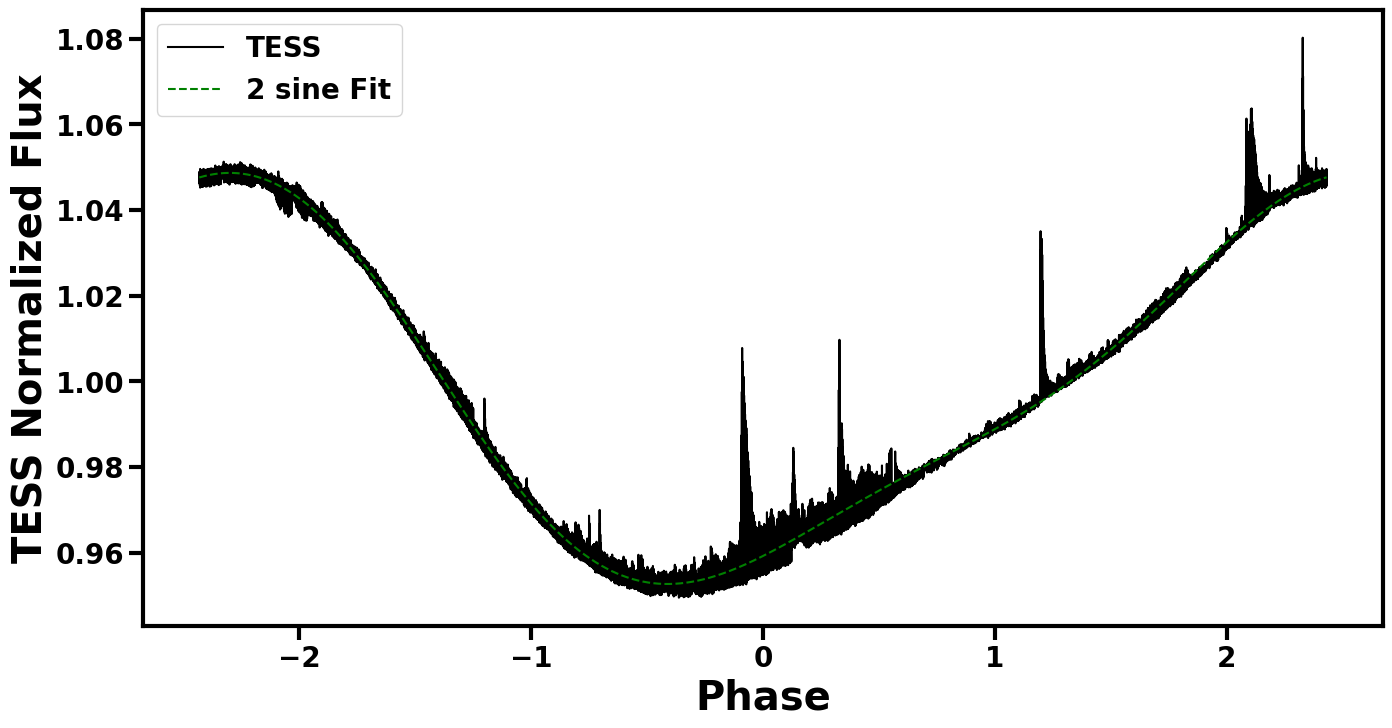

In [6]:


stella_data = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/data_analysis/tess/stella_lc.csv')
stella_lc = lk.LightCurve(flux=stella_data['flux'], time=stella_data['time'], flux_err=stella_data['flux_err'])#.normalize()

with open('../tess/stella_probabilities.npy', 'rb') as f:
    avg_pred = np.load(f)

stella_lc.add_column(avg_pred, name='stella_prob'
                     )
# Now we'll fold it and write it into continuous arrays for the FFT
stella_lc_folded = stella_lc.copy().fold(4.86, epoch_time=2400000, epoch_phase=3)
x = np.ascontiguousarray(stella_lc_folded.time.value, dtype=np.float64)
y = np.ascontiguousarray(stella_lc_folded.flux, dtype=np.float64)
yerr_scaled = np.ascontiguousarray(stella_lc_folded.flux_err * stella_lc_folded['stella_prob'], dtype=np.float64)
yerr = np.ascontiguousarray(stella_lc_folded.flux_err, dtype=np.float64)

p02 = [np.pi/70, np.max(y) - np.min(y), 3, np.max(y), (np.max(y) - np.min(y))/2, 3, np.max(y)]

def model_sine2(X, omega, amp, phase, offset1, amp2, phase2, offset2):
    return amp * np.sin(omega * X + phase) + offset1 + amp2 * np.sin(omega/2 * X + phase2) + offset2

poptsin2, pcovsine2 = curve_fit(model_sine2, x.tolist(), y,
                  p0=p02,
                  maxfev=50000)

stella_lc_og = stella_lc.copy()
x_og = np.ascontiguousarray(stella_lc_og.time.value, dtype=np.float64)
y_og = np.ascontiguousarray(stella_lc_og.flux, dtype=np.float64)
yerr_og_scaled = np.ascontiguousarray(stella_lc_og.flux_err * stella_lc_og['stella_prob'], dtype=np.float64)
yerr_og_not = np.ascontiguousarray(stella_lc_og.flux_err, dtype=np.float64)


afig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 1, 1)
ax.plot(x, y, label='TESS', color='k')
ax.plot(x, model_sine2(x, *poptsin2), 'g--', label='2 sine Fit')

print('Parameters for 2-sine fit are:\n ω={:.8} \n (sin of f) A1={:.8f}, φ1={:.8f}, C1={:.8f} \n (sin of f/2) A2={:.8f}, φ2={:.8f}, C2={:.8f}'.format(*poptsin2))
print('Functional form of 2-sine fit is:\n Flux = A1*sin(ω*t + φ1) + C1 + A2*sin(ω/2*t + φ2) + C2')
ax.set_ylabel('TESS Normalized Flux')
ax.set_xlabel('Phase')
ax.legend(markerscale=10)

In [7]:

hst_days = [(2460809.7770374413, 2460810.10588031), (2460818.233912621, 2460818.5666751266), (2460826.4921415113, 2460826.8228429067),
(2460835.2038892913, 2460835.5353429066)]

cheops_days = [(2460827.4291018597, 2460827.738845379), (2460826.6806421145, 2460827.381607217),
(2460834.964947009, 2460835.133426169), (2460835.1618256704, 2460835.817190319)]

jwst_days = [(2460818.3330352814, 2460818.7497526538), (2460835.259565584, 2460835.676293359),
(2460809.8923711404, 2460810.3091083206), (2460826.7961735446, 2460827.21288887)]   

tess = [(2460881, 2460907)]

/var/folders/s0/h_46lpt56ll2ptpy3684xkym0000gn/T/ipykernel_53852/3111820718.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


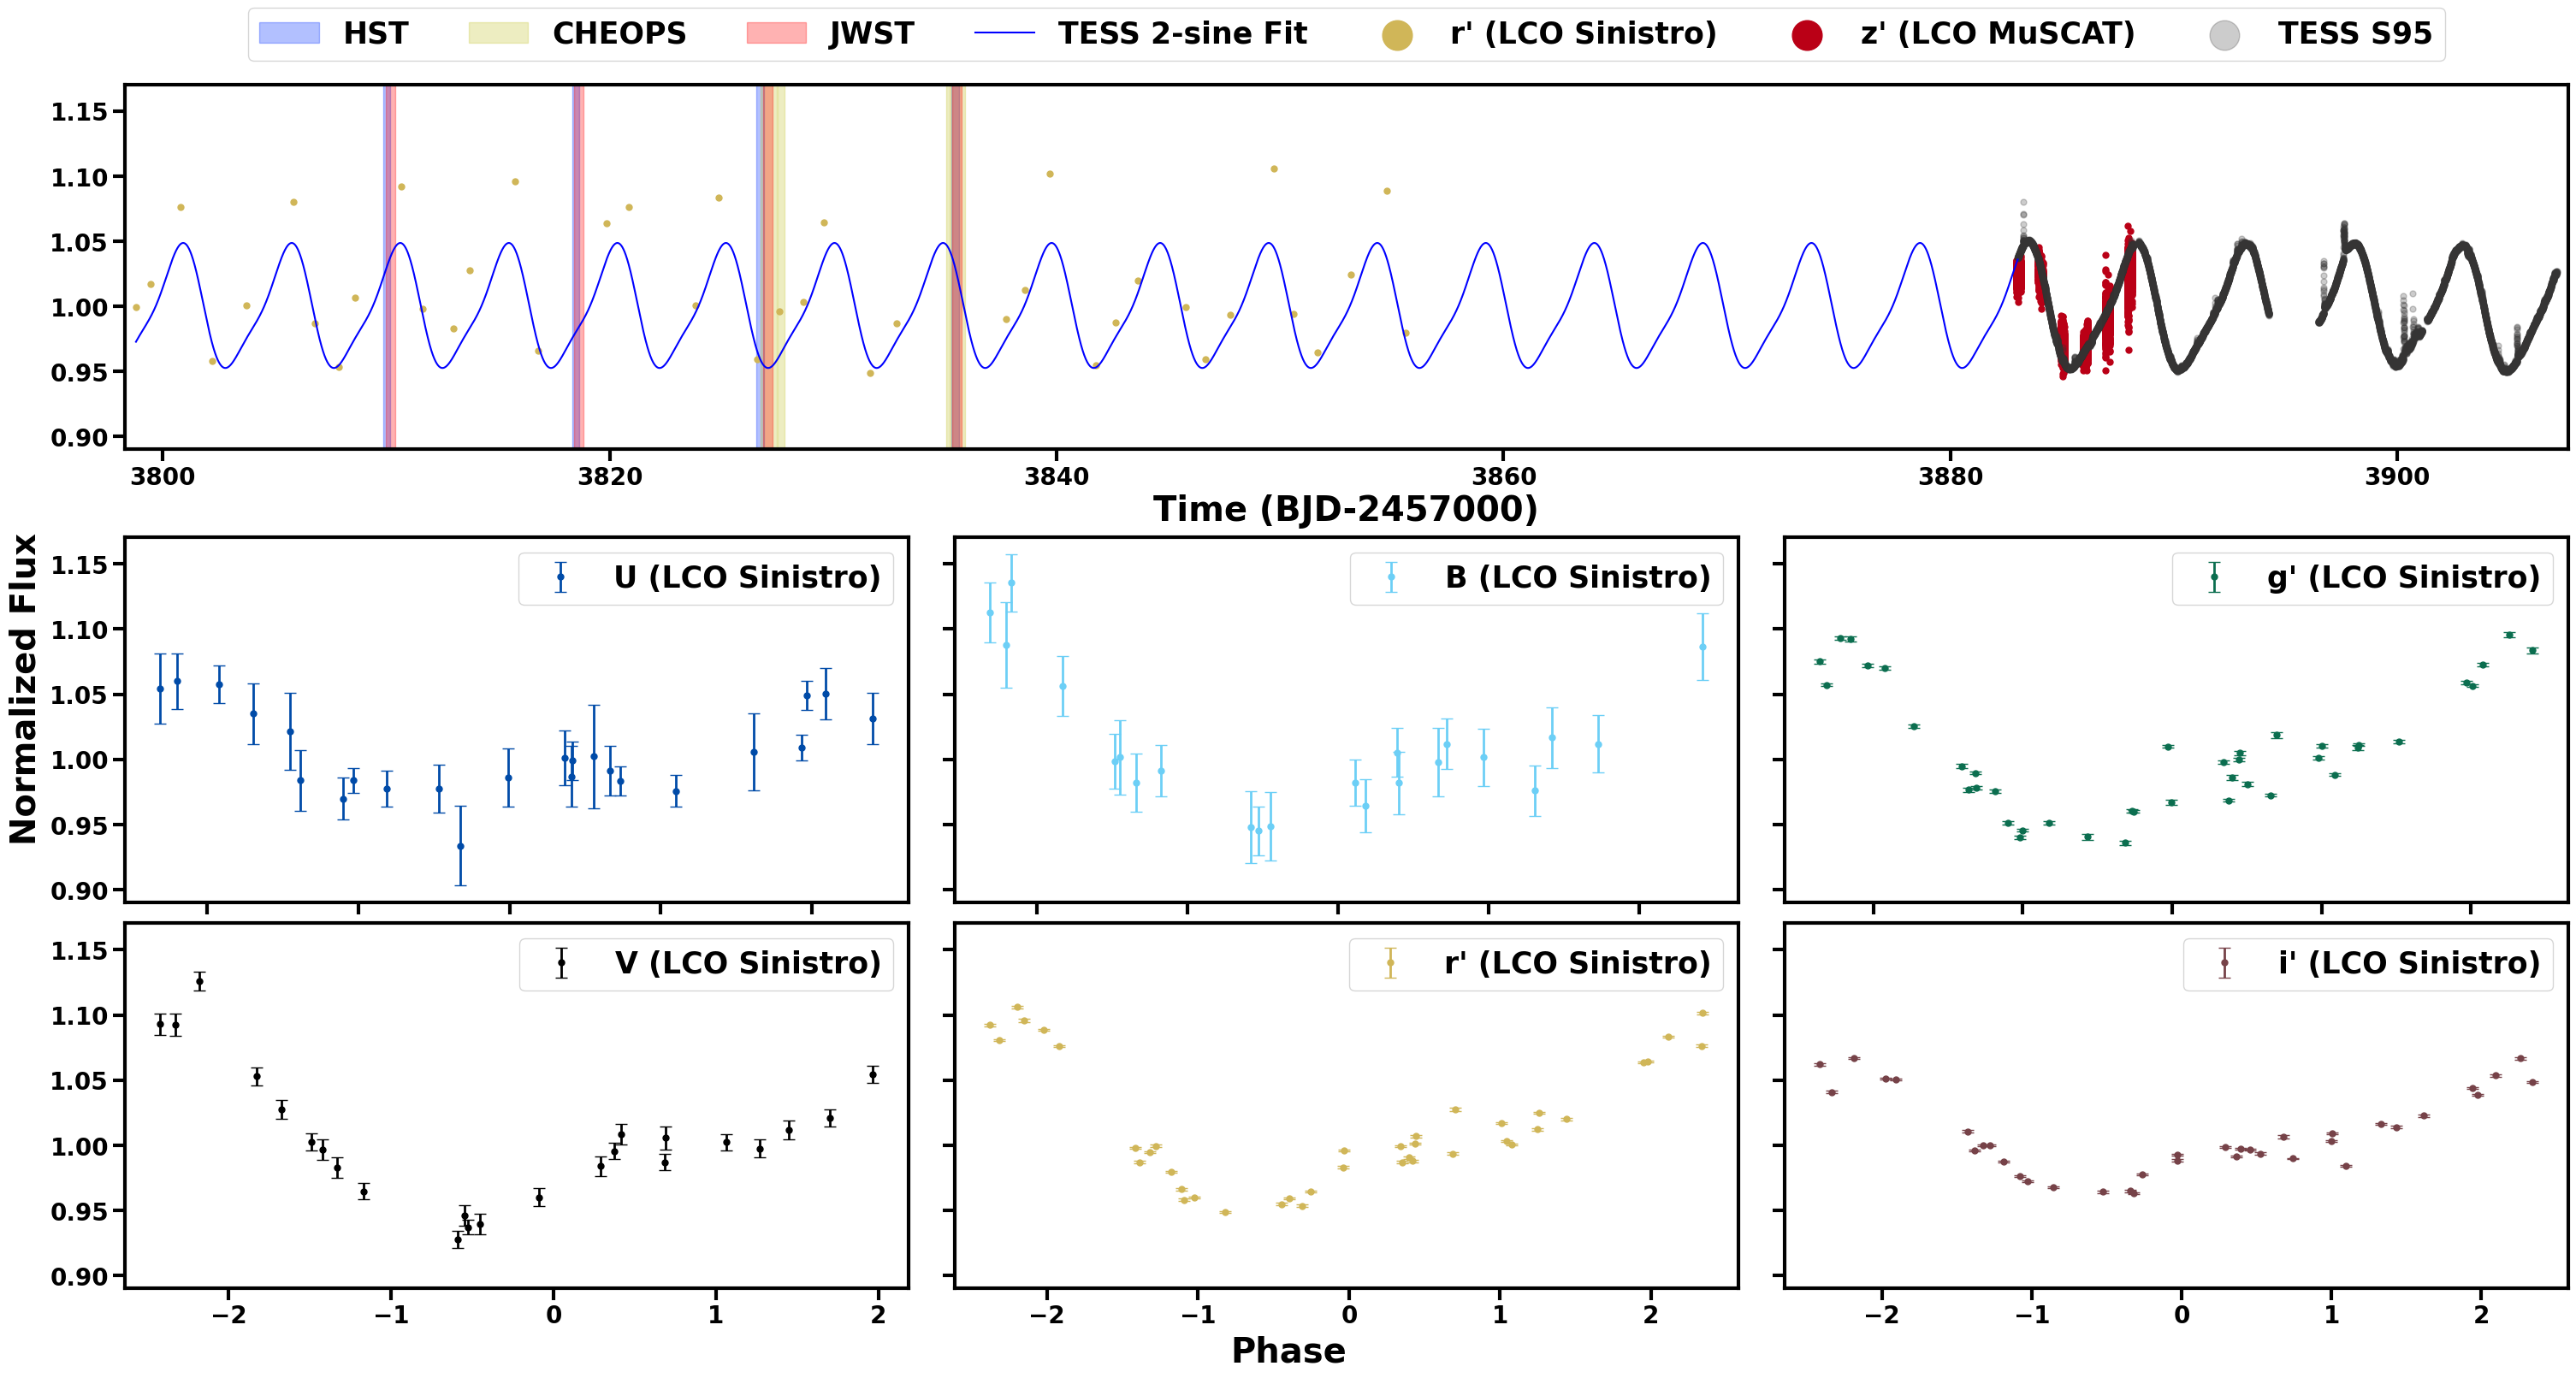

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(30, 16), facecolor='w')
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)


ax1 = fig.add_subplot(spec[0, :])
ax2 = fig.add_subplot(spec[1, 0], sharey=ax1)
ax5 = fig.add_subplot(spec[2, 0], sharey=ax1)

ax3 = fig.add_subplot(spec[1, 1], sharey=ax1)
ax4 = fig.add_subplot(spec[1, 2], sharey=ax1)
ax6 = fig.add_subplot(spec[2, 1], sharey=ax1)
ax7 = fig.add_subplot(spec[2, 2], sharey=ax1)


# Plot MuSCAT z', Sinistro i', and TESS data along with the bands for HST, CHEOPS, and JWST
for num, info in enumerate(zip([hst_days, cheops_days, jwst_days], ["#002FFF", "#C6C634", "#FF0000"], ['HST', 'CHEOPS', 'JWST'])):
    day_range, color, label = info
    for num, (start, end) in enumerate(day_range):
        if num==0:
            ax1.axvspan(start-2456999.915, end-2456999.915, color=color, alpha=0.3, label=label)
        else:
            ax1.axvspan(start-2456999.915, end-2456999.915, color=color, alpha=0.3)

model_times = np.linspace(np.min(rp_binned.time.value), np.min(stella_lc_og.time.value), 20000)
model = ax1.plot(model_times, model_sine2(model_times, *poptsin2), c='b', label='TESS 2-sine Fit')
rp_binned.scatter(ax=ax1, s=100,  label='r\' (LCO Sinistro)', c="#D0B658")
zslc.scatter(ax=ax1, s=100, label='z\' (LCO MuSCAT)', c="#BA0016")
stella_lc_og.scatter(ax=ax1, s=100, c="#353434", label='TESS S95', alpha=0.25)
    
[curve.errorbar(ax=axs, markersize=5, fmt='o', elinewidth=2, capsize=5, 
                label=label, c=color) for curve, axs, label, color in zip(
                    [U_lc, B_lc, gp_lc, V_lc, rp_lc, ip_lc], [ax2, ax3, ax4, ax5, ax6, ax7],
                    ['U (LCO Sinistro)', 'B (LCO Sinistro)', 'g\' (LCO Sinistro)', 'V (LCO Sinistro)', "r\' (LCO Sinistro)", "i\' (LCO Sinistro)"], 
                    ["#004BA8", "#6CCFF6", '#0B6E4F', "#000000", "#D0B658", '#764248'])]


ax1.set_ylabel('')

[ax.set_ylabel('') for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]]
[ax.set_xlabel('') for ax in [ax2, ax3, ax4, ax5, ax6, ax7]]


lgnd = ax1.legend(fontsize=25, facecolor='w', labelcolor='k', ncols=7, bbox_to_anchor=(0.5, 1.25), loc='upper center', markerscale=5)

[ax.legend(fontsize=25, facecolor='w', labelcolor='k') for ax in [ax2, ax3, ax4, ax5, ax6, ax7]]

ax1.set_xlim(np.min(rp_binned.time.value)-0.5, np.max(stella_lc_og.time.value)+0.5)

for num, ax in enumerate(plt.gcf().axes):
    if num==0:
        continue   
    else:
        ax.label_outer()

fig.supylabel('Normalized Flux')
fig.supxlabel('Phase')
ax1.set_xlabel('Time (BJD-2457000)')
fig.show()